In [1]:
import copy
import numpy as np
import tensorflow as tf

# Simple RL
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Torch
import torch
import torch.optim as optim
from torch import FloatTensor
from torch.autograd import Variable

# https://github.com/pandas-profiling/pandas-profiling/issues/68
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# MLIRL [1]

In [2]:
# Modified to handle given goal scenario.
def MLIRL(state_trajectories, action_trajectories, states, state_features,
              actions, trans_dict, optimizer_fn, n_iter=1, n_vi_iter=1,
              gamma=0.99, boltzmann_beta=1., dtype=torch.float64,
              print_interval=1, grad_eps=1e-3, w_init_scheme=None, w_init=None,
              goal_is_given=False):
    
    assert w_init_scheme in ["random", "zeros", "custom"]
    assert len(states) == len(state_features)
    
    nS = len(states)
    nA = len(actions)
    state_features = torch.from_numpy(state_features).type(dtype)
    feature_dim = state_features.shape[1]
    state_to_idx = {s:idx for idx,s in enumerate(states)}
    action_to_idx = {a:idx for idx,a in enumerate(actions)}
    softmax = torch.nn.Softmax(dim=0)
    
    # Reward parameters
    if w_init_scheme == "custom":
        assert w_init is not None
        w = Variable(torch.Tensor(w_init).type(dtype), requires_grad=True)
    elif w_init_scheme == "zeros":
        w = Variable(torch.zeros(feature_dim, 1).type(dtype), requires_grad=True)
    elif w_init_scheme == "random" or w_init_scheme is None:
        w = Variable(torch.Tensor(feature_dim, 1).normal_(0, 0.01).type(dtype), requires_grad=True)
        
    # Optimization variables
    optimizer = optimizer_fn([w])
    
    for _iter in range(n_iter):
        
        loss = 0
        for traj_idx, state_trajectory in enumerate(state_trajectories):
            
            _goal_state = state_trajectory[-1]
            
            # Stochastic Policy
            Pi = torch.ones(nS, nA, dtype=dtype) / nA
            # Reward^~
            R = torch.mm(state_features, w)            
            # Value
            V = R[:,0].clone()
            # Q value
            Q = R.repeat(1,nA).clone()
            
            if goal_is_given:
                # Assume goal state is given (we want V[goal]=0 and absorbing, so that we learn navigation cost features not navigation to the goal.)
                V[state_to_idx[_goal_state]] = 0
                
            for _v_iter in range(n_vi_iter):
                for s_idx, s in enumerate(states):

                    # Check if state is terminal (stop leaking values back to non-goal state space)
                    if s.is_terminal() or (goal_is_given and s == _goal_state):
                        continue

                    phi_s = state_features[s_idx]
                    for a_idx, a in enumerate(actions):

                        Q[s_idx, a_idx] = R[s_idx]
                        for s_prime in trans_dict[s][a]:                            
                            Q[s_idx, a_idx] += gamma * trans_dict[s][a][s_prime] * V[state_to_idx[s_prime]].clone()
                        Pi[s_idx, :] = softmax(boltzmann_beta * Q[s_idx,:].clone())
                        V[s_idx] = Pi[s_idx, :].clone().dot(Q[s_idx,:].clone())
                        
            for point_idx, state in enumerate(state_trajectory[:-1]):
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action_trajectories[traj_idx][point_idx]]
                loss -= torch.log(Pi[s_idx,a_idx])
                
        optimizer.zero_grad()
        loss.backward()
        grad_l2 = w.grad.norm(2)
        if _iter % print_interval == 0 or _iter == n_iter-1:
            print("Iter: {:04d}, loss: {:012.6f}, w: [{}], dw: [{}], l2(dw): {}".format(
                _iter, loss, ' '.join("{:+10.8f}".format(v) for v in w[:,0]), ' '.join("{:+10.9f}".format(v) for v in -w.grad[:,0]), grad_l2))
            
        if grad_eps is not None and grad_l2 < grad_eps:
            print("Converged at iteration {}.".format(_iter))
            break
            
        optimizer.step()
    return w, R, Pi, V, Q, loss

# Experiments

In [13]:
def get_action(state, n_state):
    dx = n_state[0] - state[0]
    dy = n_state[1] - state[1]
    if dx > 0 and dy == 0: return "right"
    elif dx > 0 and dy > 0: return "up_right"
    elif dx == 0 and dy > 0: return "up"
    elif dx < 0 and dy > 0: return "up_left"
    elif dx < 0 and dy == 0: return "left"
    elif dx < 0 and dy < 0: return "down_left"
    elif dx == 0 and dy < 0: return "down"
    elif dx > 0 and dy < 0: return "down_right" 
    else: return "stay" #dx == 0 and dy == 0:
    
def get_traj_actions(tau_s):
    return [[get_action(state_traj[i], state_traj[i+1]) for i in range(len(state_traj)-1)] for state_traj in tau_s]

def get_traj_states(tau_s):
    return [[GridWorldState(x,y) for (x,y) in state_traj] for state_traj in tau_s]

def map_v_to_grid(states, V, nvmdp):
    V_grid = np.zeros((nvmdp.height, nvmdp.width))
    for i in range(len(states)):
        r, c = nvmdp._xy_to_rowcol(states[i].x, states[i].y)
        V_grid[r,c] = V[i]
    return V_grid

def compute_new_value(results):
    nvmdp_ = copy.deepcopy(results["nvmdp"])
    living_rewards_pred = np.array([nvmdp_.cell_type_feature(i) for i in nvmdp_.living_cell_ids]).dot(results["w"].data).reshape(-1,1).tolist()
    if len(nvmdp_.goal_cell_ids) == 0:
        goal_rewards_pred = []
    else:
        goal_rewards_pred = np.array([nvmdp_.cell_type_feature(i) for i in nvmdp_.goal_cell_ids]).dot(results["w"].data).reshape(-1,1).tolist()
    nvmdp_._reset_rewards(living_rewards_pred, goal_rewards_pred)
    return nvmdp_.get_value_grid()

def MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=True, figsize=(10,10), print_interval=1):
    
    nvmdp = irl_problem["nvmdp"]
    traj_states, traj_actions = irl_problem["s_a_trajectories"]
    
    # Visualize Grid
    if disp_grid:
        nvmdp.visualize_grid(nvmdp.state_space, trajectories=traj_states, state_space_cmap=plt.cm.viridis, end_marker="*k", goal_marker_sz=10)
        
    # MLIRL Inputs
    phi = lambda s: nvmdp.feature_at_state(s, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    phi_loc = lambda x,y: nvmdp.feature_at_loc(x, y, "indicator", incl_cell_distances=False, incl_goal_indicator=True, incl_goal_distances=False, normalize_distance=False)
    states = nvmdp.get_states()
    actions = nvmdp.get_actions()
    state_features = np.asarray([phi(s) for s in states])
    cell_features = np.asarray([[phi_loc(*nvmdp._rowcol_to_xy(row,col)) for col in range(nvmdp.width)] for row in range(nvmdp.height)])
    T = nvmdp.get_trans_dict()
    
    # MLIRL
    print("Training...\n \t\t\t\t \t {}  \t {} ".format(' '.join("{:11}".format(v) for v in nvmdp.cell_types), ' '.join("{:11}".format(v) for v in nvmdp.cell_types)))
    w, _, Pi, V, Q, loss = MLIRL(traj_states, traj_actions, states, state_features, actions, T, **mlirl_params, print_interval=print_interval)
    print("Done.")
    
    # Recovered Reward
    R = cell_features.dot(w.data)[:,:,0]
    
    # Display results
    if disp_results:
        display_irl_results(nvmdp, traj_states, R, V_grid, title, figsize)
    return dict(w=w, R=R, Pi=Pi, V=V, Q=Q, nvmdp=nvmdp, phi=phi, phi_loc=phi_loc)

def display_irl_results(nvmdp, tau_s, recovered_R, V=None, rewards_cmap=None, figsize=(16,8), r_fig_suffix=""):
    
    traj_states = get_traj_states(tau_s)
    
    plt.figure(figsize=figsize)
    nvmdp.visualize_grid(nvmdp.state_space, new_fig=False, subplot_str="221", trajectories=traj_states,
                         state_space_cmap=True, show_colorbar=True, show_rewards_colorbar=True, end_marker="*k")
    nvmdp.visualize_grid(recovered_R, new_fig=False, subplot_str="222", cmap=rewards_cmap, state_space_cmap=False,
                         show_colorbar=True, text_values=recovered_R, text_size=10, title="Recovered R" + r_fig_suffix)
    if V is not None:
        nvmdp.visualize_grid(V, new_fig=False, subplot_str="223", state_space_cmap=False, show_colorbar=True, text_values=V, text_size=10, title="Recovered Value")

# Navigation MDP

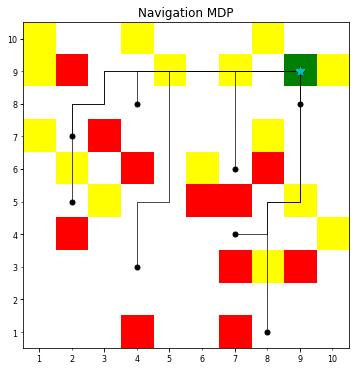

Training...
 				 	 white       yellow      red         green        	 white       yellow      red         green       
Iter: 0000, loss: 00026.609037, w: [-1.44754159 -1.04165983 -1.61109531 +0.00000000], dw: [-5.958848000 -0.742116332 -5.039322853 -0.000000000], l2(dw): 7.8392205238342285
Iter: 0001, loss: 00025.694775, w: [-1.54754162 -0.94165993 -1.71109533 +0.00000000], dw: [-4.666959763 -1.487410307 -4.918600082 -0.000000000], l2(dw): 6.941579818725586
Iter: 0002, loss: 00024.748245, w: [-1.64498258 -0.97467333 -1.81086671 +0.00000000], dw: [-3.783057213 -1.468826056 -4.842969418 -0.000000000], l2(dw): 6.318490505218506
Iter: 0003, loss: 00023.867762, w: [-1.73837185 -1.03438723 -1.91031504 +0.00000000], dw: [-3.063066244 -1.315001965 -4.778363228 -0.000000000], l2(dw): 5.826179027557373
Iter: 0004, loss: 00023.075937, w: [-1.82577300 -1.09986806 -2.00932956 +0.00000000], dw: [-2.471899271 -1.142208815 -4.716453552 -0.000000000], l2(dw): 5.446086883544922
Iter: 0005, loss: 00022.

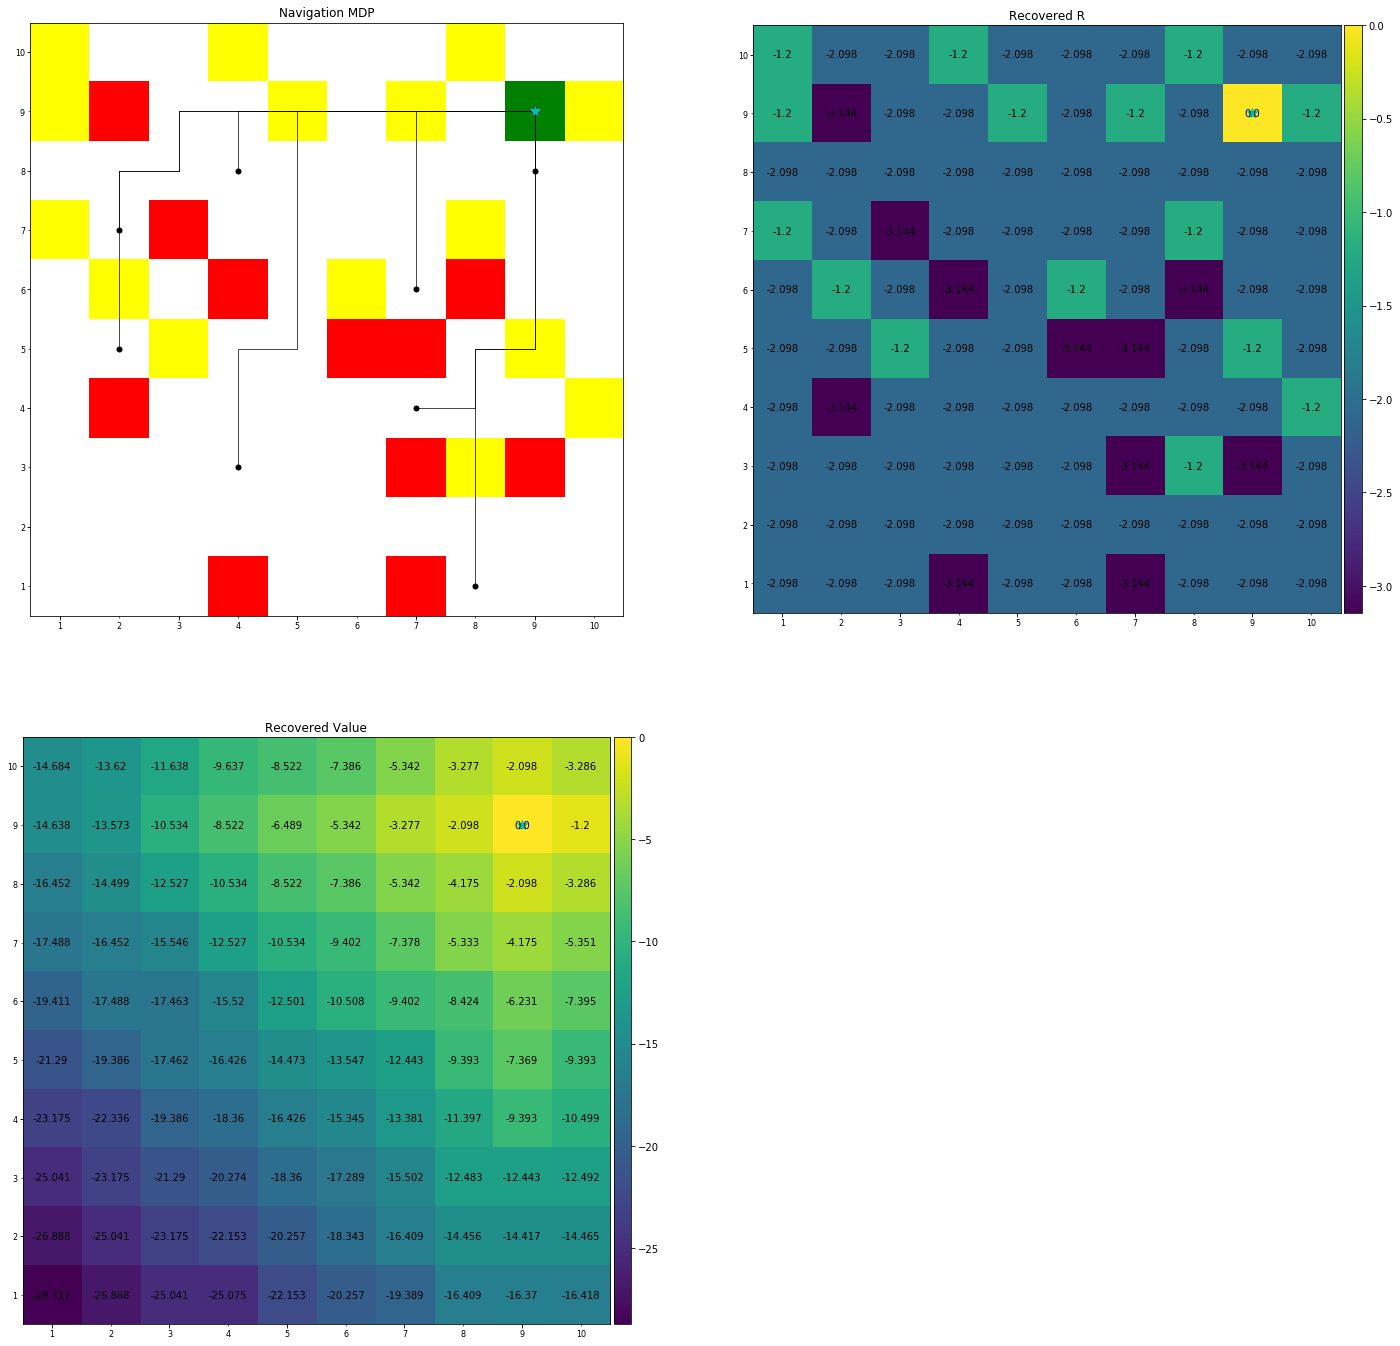

In [8]:
np.random.seed(10)
nvmdp = NavigationMDP(
    width = 10,
    height = 10,
    living_cell_distribution = "probability",
    living_cell_types = ['white', 'yellow', 'red'],
    living_cell_type_probs=[0.68, 0.17, 0.15],
    living_cell_rewards = [0, 0, -10],
    goal_cell_types = ["green"],
    goal_cell_locs = [(9, 9)],
    goal_cell_rewards = [1.],
    name = "Navigation MDP"
    )
mlirl_params = dict(
    n_iter = 100,
    n_vi_iter = 20,
    dtype = torch.float,
    gamma = 0.95,
    boltzmann_beta = 1.,
    w_init_scheme = "random",
    # w_init = results["w"].data.numpy(),
    grad_eps = 1e-2,
    optimizer_fn = lambda params: optim.Adam(params, lr=0.1, weight_decay=1.),
    goal_is_given = True,
    )
irl_problem = dict(
    nvmdp = nvmdp,
    s_a_trajectories = nvmdp.sample_data(8)
    )
results = MLIRL_experiment(irl_problem, mlirl_params, disp_grid=True, disp_results=False)
display_irl_results(results["nvmdp"], irl_problem["s_a_trajectories"][0], results["R"].round(3), 
                     compute_new_value(results).round(3), figsize=(24,24))

# References

[1] Babes, Monica, et al. "Apprenticeship learning about multiple intentions." Proceedings of the 28th International Conference on Machine Learning (ICML-11). 2011.  